In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from imblearn.pipeline import make_pipeline

In [50]:
df = pd.read_csv('Final_2_cleaned.csv')

In [51]:
df.head(10)

,Rank,Ticker,Company Name,Industry,Sector,Country,Profit (Billion $),Revenue (Billion $),Assets (Billion $),Market Value (Billion $),...,Current Price,52 Week High,52 Week Low,CEO,Gender,EBITDA,Rating,Beta,No of Employees,Founding Year
0,1.0,JPM,JPMorganChase,Banks - Diversified,Financial Services,United States,50.0,252.9,4090.7,588.1,...,267.30,270.82,172.62,James Dimon,Male,74.63,3.0,1.09,317233,1980
1,2.0,BRK-B,Berkshire Hathaway,Insurance - Diversified,Financial Services,United States,73.4,369.0,1070.0,899.1,...,468.67,491.67,389.29,Warren E. Buffett,Male,0.00,3.0,0.86,392400,1996
2,3.0,2222.SR,Saudi Arabian Oil Company (Saudi Aramco),Oil & Gas Integrated,Energy,Saudi Arabia,116.9,489.1,661.5,1919.3,...,27.65,32.65,26.80,Amin H. Nasser,Male,996.71,3.0,0.17,67947,2019
3,4.0,1398.HK,ICBC,Banks - Diversified,Financial Services,China,50.4,223.8,6586.0,215.2,...,5.28,5.36,3.75,Chen Siqing,Male,12.18,3.0,0.97,72000,1980
4,5.0,BAC,Bank of America,Banks - Diversified,Financial Services,United States,25.0,183.3,3273.8,307.3,...,46.30,48.08,32.35,Brian T. Moynihan,Male,29.25,1.0,1.33,213000,1973
5,6.0,AMZN,Amazon,Internet Retail,Consumer Cyclical,United States,37.7,590.7,531.0,1922.1,...,237.68,241.77,151.61,Jeffrey P. Bezos,Male,123.82,3.0,1.19,1556000,1997
6,7.0,601939.SS,China Construction Bank,Banks - Diversified,Financial Services,China,47.0,199.8,5403.8,187.5,...,8.54,9.02,6.65,Tian Guoli,Male,12.18,3.0,0.97,72000,1980
7,8.0,MSFT,Microsoft,Software - Infrastructure,Technology,United States,86.2,236.6,484.3,3123.1,...,415.06,468.35,385.58,Satya Nadella,Male,133.01,3.0,0.90,228000,1986
8,9.0,601288.SS,Agricultural Bank of China,Banks - Diversified,Financial Services,China,37.4,193.5,5832.9,170.9,...,5.16,5.44,3.90,Zhang Qingsong,Male,12.18,3.0,0.97,72000,1980
9,10.0,GOOG,Alphabet,Internet Content & Information,Communication Services,United States,82.4,317.9,407.4,2177.7,...,205.60,207.08,131.55,Larry Page,Male,112.39,4.0,1.02,183323,2004


In [52]:
numeric_cols = ['Profit (Billion $)', 'Revenue (Billion $)', 
                'Assets (Billion $)', 'EBITDA', 'Market Cap(Billion $)']
target = 'Rating'

In [53]:
df[target] = pd.to_numeric(df[target], errors='coerce')
rating_median = df[target].median()
df[target] = df[target].fillna(rating_median).astype(int)

for col in numeric_cols:
    col_median = df[col].median()
    df[col] = pd.to_numeric(df[col], errors='coerce')  # ensure numeric
    df[col] = df[col].fillna(col_median)

In [54]:
# Feature Engineering
df['Profit_Margin'] = df['Profit (Billion $)'] / df['Revenue (Billion $)']
df['ROA'] = df['Profit (Billion $)'] / df['Assets (Billion $)']
df['EBITDA_to_Revenue'] = df['EBITDA'] / df['Revenue (Billion $)']
df['Market_to_Book'] = df['Market Cap(Billion $)'] / df['Assets (Billion $)']

In [55]:
ratio_cols = ['Profit_Margin', 'ROA', 'EBITDA_to_Revenue', 'Market_to_Book']
for col in ratio_cols:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    df[col] = df[col].fillna(df[col].median())

In [56]:
features = numeric_cols + ratio_cols

In [57]:
print("Sample of processed data:")
print(df[features + [target]].head(10))

Sample of processed data:
   Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
0                50.0                252.9              4090.7   74.63   
1                73.4                369.0              1070.0    0.00   
2               116.9                489.1               661.5  996.71   
3                50.4                223.8              6586.0   12.18   
4                25.0                183.3              3273.8   29.25   
5                37.7                590.7               531.0  123.82   
6                47.0                199.8              5403.8   12.18   
7                86.2                236.6               484.3  133.01   
8                37.4                193.5              5832.9   12.18   
9                82.4                317.9               407.4  112.39   

   Market Cap(Billion $)  Profit_Margin       ROA  EBITDA_to_Revenue  \
0                 747.80       0.197707  0.012223           0.295097   
1              

In [58]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

In [59]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print("Class distribution in training set:", pd.Series(y_train).value_counts().to_dict())
print("Class distribution in testing set:", pd.Series(y_test).value_counts().to_dict())

Training set size: 142 samples
Testing set size: 48 samples
Class distribution in training set: {3: 101, 2: 28, 4: 11, 1: 2}
Class distribution in testing set: {3: 34, 2: 10, 4: 3, 1: 1}


In [60]:
print("Training set sample:")
print(X_train.head())
print(y_train.head())


Training set sample:
     Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
110                10.1                 54.0               103.5   23.16   
158                 2.4                 24.1               127.6    9.55   
171               807.0                 13.1                24.8    2.63   
168               -10.8                 14.1                33.2    4.10   
114                 7.3                 55.3               100.0   23.52   

     Market Cap(Billion $)  Profit_Margin        ROA  EBITDA_to_Revenue  \
110                  98.32       0.187037   0.097585           0.428889   
158                  36.25       0.099585   0.018809           0.396266   
171                  25.37      61.603053  32.540323           0.200763   
168                   4.98      -0.765957  -0.325301           0.290780   
114                 125.87       0.132007   0.073000           0.425316   

     Market_to_Book  
110        0.949952  
158        0.284091  
171  

In [61]:
print("\nTesting set sample:")
print(X_test.head())
print(y_test.head())


Testing set sample:
     Profit (Billion $)  Revenue (Billion $)  Assets (Billion $)  EBITDA  \
173                 1.4                 16.8               353.9    0.00   
17                 22.7                399.1               388.1   12.18   
147                 4.4                 48.0               212.3   12.18   
8                  37.4                193.5              5832.9   12.18   
169                 1.4                 14.3                 9.8    2.23   

     Market Cap(Billion $)  Profit_Margin       ROA  EBITDA_to_Revenue  \
173                   6.59       0.083333  0.003956           0.000000   
17                 1576.23       0.056878  0.058490           0.030519   
147                 150.17       0.091667  0.020725           0.253750   
8                  1768.58       0.193282  0.006412           0.062946   
169                  40.24       0.097902  0.142857           0.155944   

     Market_to_Book  
173        0.018621  
17         4.061402  
147        

In [62]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [63]:
class_counts = Counter(y_train)
n_samples = len(y_train)
n_classes = len(class_counts)

In [64]:
class_weights = {cls: n_samples / (n_classes * count) for cls, count in class_counts.items()}
print("Computed class weights:", class_weights)

Computed class weights: {2: 1.2678571428571428, 4: 3.227272727272727, 3: 0.35148514851485146, 1: 17.75}


In [65]:
def combined_kernel(X, Y):
    gamma_rbf = 0.1
    degree_poly = 2
    coef0 = 1.0
    
    rbf_component = rbf_kernel(X, Y, gamma=gamma_rbf)
    poly_component = polynomial_kernel(X, Y, degree=degree_poly, coef0=coef0)

    return 0.7 * rbf_component + 0.3 * poly_component

In [66]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid', 'precomputed']
costs = [0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
results = {}

In [67]:
print("\nRunning grid search for standard kernels...")
param_grid = {
    'C': costs,
    'kernel': kernels[:4],  
    'gamma': gammas,
    'class_weight': [class_weights, 'balanced']
}


Running grid search for standard kernels...


In [69]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy',verbose=1,n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': [{1: 17.75, 2: 1.2678571428571428,
                                           3: 0.35148514851485146,
                                           4: 3.227272727272727},
                                          'balanced'],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [70]:
best_model = grid_search.best_estimator_
print(f"\nBest standard kernel model: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2%}")


Best standard kernel model: {'C': 10, 'class_weight': {2: 1.2678571428571428, 4: 3.227272727272727, 3: 0.35148514851485146, 1: 17.75}, 'gamma': 1, 'kernel': 'poly'}
Best score: 52.00%


In [71]:
standard_preds = best_model.predict(X_test_scaled)
standard_acc = accuracy_score(y_test, standard_preds)
standard_cm = confusion_matrix(y_test, standard_preds)

In [72]:
print("\nEvaluating custom combined kernel...")

K_train = combined_kernel(X_train_scaled, X_train_scaled)
K_test = combined_kernel(X_test_scaled, X_train_scaled)


Evaluating custom combined kernel...


In [73]:
custom_results = []
for C in costs:
    model = SVC(
        kernel='precomputed',
        C=C,
        class_weight=class_weights
    )
    model.fit(K_train, y_train)
    custom_preds = model.predict(K_test)
    custom_acc = accuracy_score(y_test, custom_preds)
    custom_cm = confusion_matrix(y_test, custom_preds)
    
    custom_results.append({
        'C': C,
        'accuracy': custom_acc,
        'confusion_matrix': custom_cm
    })

In [74]:
best_custom = max(custom_results, key=lambda x: x['accuracy'])
print(f"Best combined kernel results (C={best_custom['C']}): {best_custom['accuracy']:.2%}")

Best combined kernel results (C=100): 45.83%


In [75]:
if best_custom['accuracy'] > standard_acc:
    print("\nCombined kernel performs better!")
    best_acc = best_custom['accuracy']
    best_cm = best_custom['confusion_matrix']
    best_type = "Combined RBF+Poly"
    best_params = f"C={best_custom['C']}"
else:
    print("\nStandard kernel performs better!")
    best_acc = standard_acc
    best_cm = standard_cm
    best_type = grid_search.best_params_['kernel']
    best_params = f"C={grid_search.best_params_['C']}, gamma={grid_search.best_params_['gamma']}"


Standard kernel performs better!


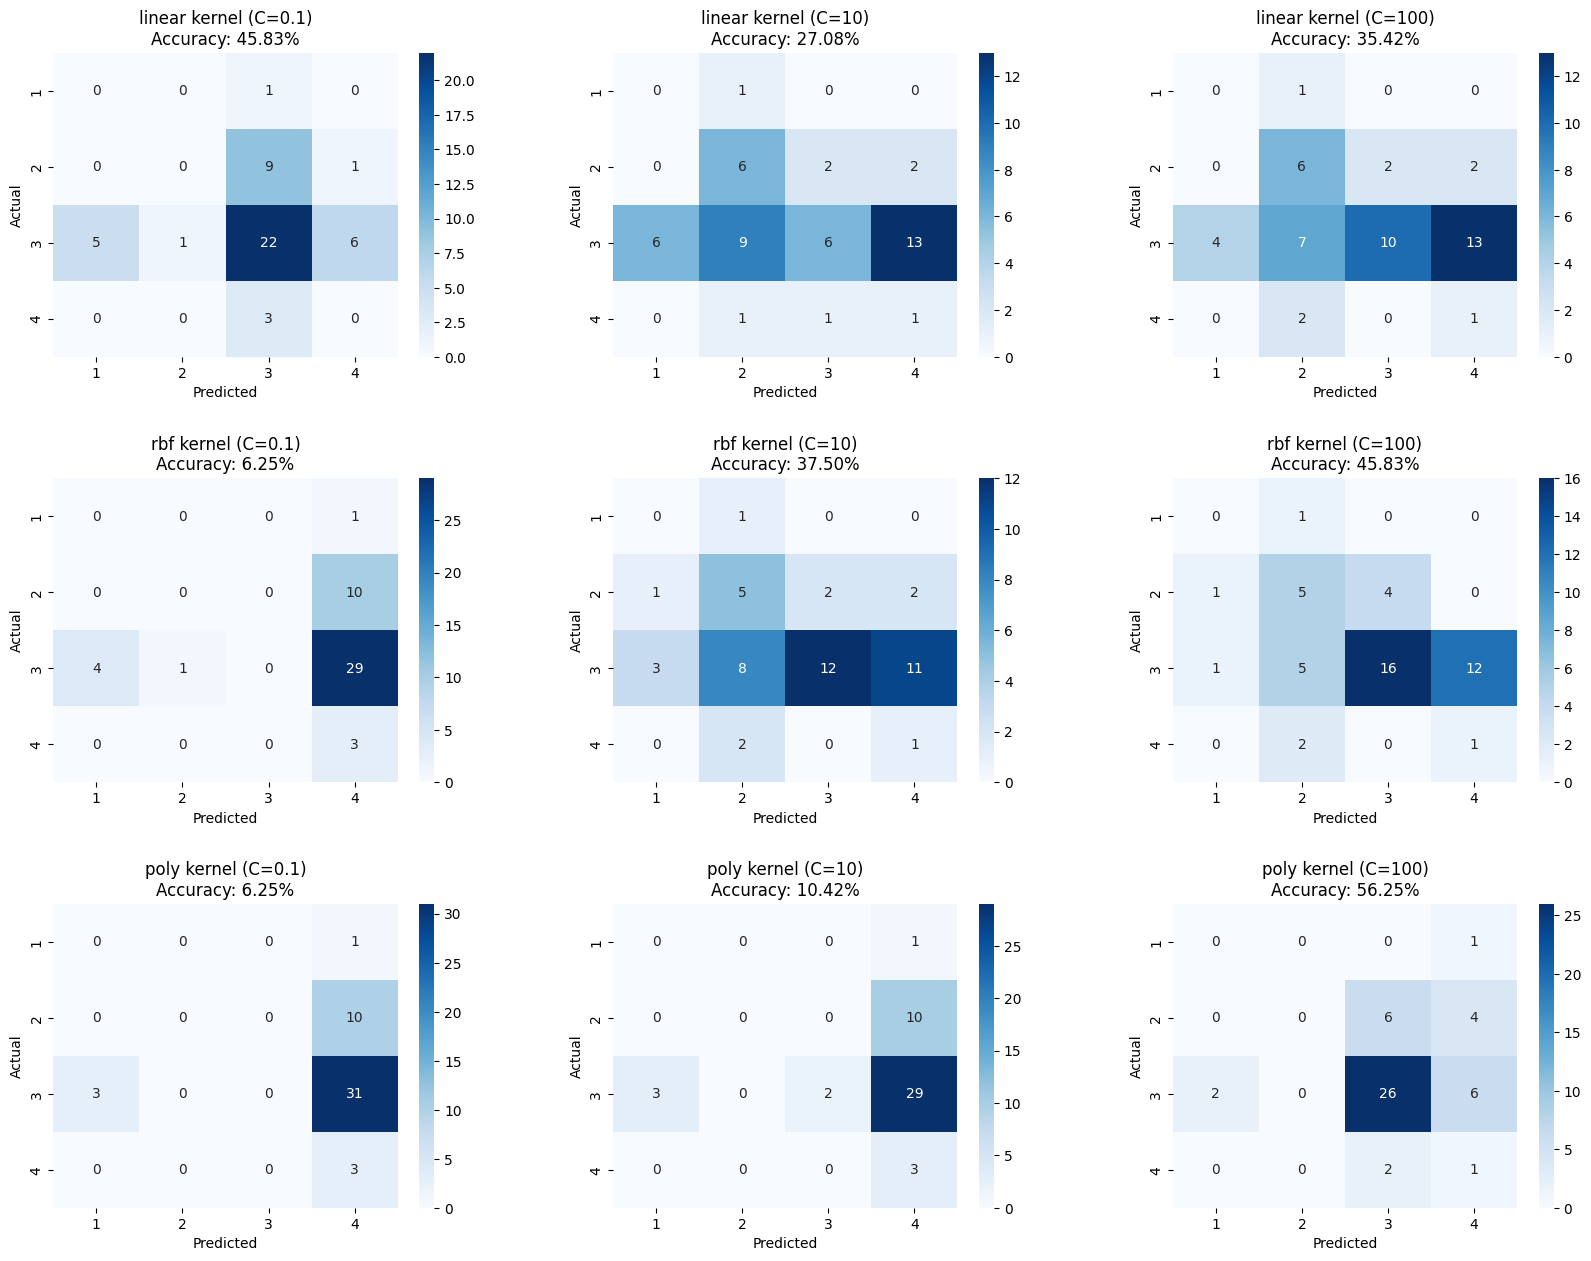

In [76]:
# Confusion matrix grid for all combinations
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 10, 100]

fig, axes = plt.subplots(len(kernels), len(C_values), figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, kernel in enumerate(kernels):
    for j, C in enumerate(C_values):
        model = SVC(kernel=kernel, C=C, class_weight='balanced', gamma='scale', random_state=42)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i,j],
                   xticklabels=np.unique(y), yticklabels=np.unique(y))
        axes[i,j].set_title(f'{kernel} kernel (C={C})\nAccuracy: {accuracy_score(y_test, y_pred):.2%}')
        axes[i,j].set_xlabel('Predicted')
        axes[i,j].set_ylabel('Actual')

# plt.savefig('confusion_matrix_grid.png', bbox_inches='tight')
plt.show()

<Figure size 1000x800 with 0 Axes>

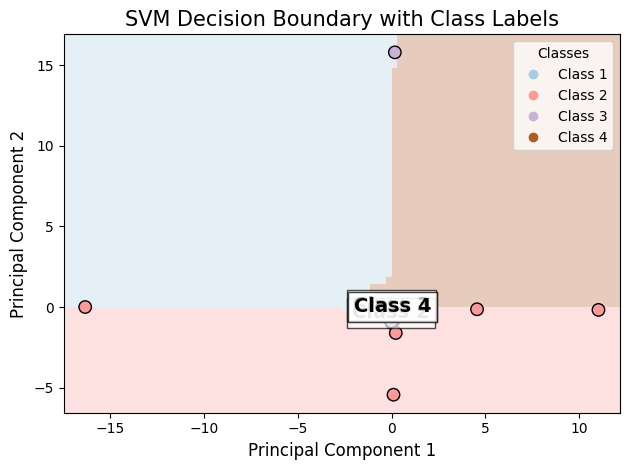

In [77]:
# # Decision boundary visualization using PCA
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train_scaled)

# best_model_pca = SVC(**grid_search.best_params_, random_state=42)
# best_model_pca.fit(X_pca, y_train)

# plt.figure(figsize=(10, 8))
# DecisionBoundaryDisplay.from_estimator(
#     best_model_pca,
#     X_pca,
#     response_method="predict",
#     cmap=plt.cm.Paired,
#     plot_method="pcolormesh",
#     alpha=0.3
# )

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

best_model_pca = SVC(**grid_search.best_params_, random_state=42)
best_model_pca.fit(X_pca, y_train)

plt.figure(figsize=(10, 8))

disp = DecisionBoundaryDisplay.from_estimator(
    best_model_pca,
    X_pca,
    response_method="predict",
    cmap=plt.cm.Paired,
    plot_method="pcolormesh",
    alpha=0.3
)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, 
                      cmap=plt.cm.Paired, edgecolors='k', s=80)
centers = {}
for class_val in np.unique(y_train):
    mask = y_train == class_val
    if np.sum(mask) > 0:
        center_x = X_pca[mask, 0].mean()
        center_y = X_pca[mask, 1].mean()
        plt.text(center_x, center_y, f'Class {class_val}', 
                 fontsize=14, fontweight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))

plt.title('SVM Decision Boundary with Class Labels', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, [f'Class {label}' for label in np.unique(y_train)],
                   title="Classes", loc="upper right")

plt.tight_layout()
plt.show()

In [46]:
# # Plot PCA-transformed test data
# X_test_pca = pca.transform(X_test_scaled)
# plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, edgecolors='k', s=50)
# plt.title(f'Decision Boundaries ({grid_search.best_params_["kernel"].upper()} Kernel)\nAccuracy: {accuracy_score(y_test, y_pred):.2%}')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.savefig('best_model_decision_boundary.png', bbox_inches='tight')
# plt.show()

In [47]:
# plt.figure(figsize=(10,8))
# sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues',xticklabels=sorted(np.unique(y)),yticklabels=sorted(np.unique(y)))
# plt.title(f'Best Model: {best_type.upper()} Kernel\n{best_params}\nAccuracy: {best_acc:.2%}')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.tight_layout()
# plt.show()

In [31]:
plt.figure(figsize=(12,6))
accuracies = []

for param in grid_search.cv_results_['params']:
    if param['class_weight'] == 'balanced':
        accuracies.append({
            'Kernel': f"{param['kernel']} (C={param['C']}, γ={param['gamma']})",
            'Accuracy': grid_search.cv_results_['mean_test_score'][
                grid_search.cv_results_['params'].index(param)
            ]
        })

accuracies.append({
    'Kernel': f"Combined RBF+Poly (C={best_custom['C']})",
    'Accuracy': best_custom['accuracy']
})

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy by C Value')

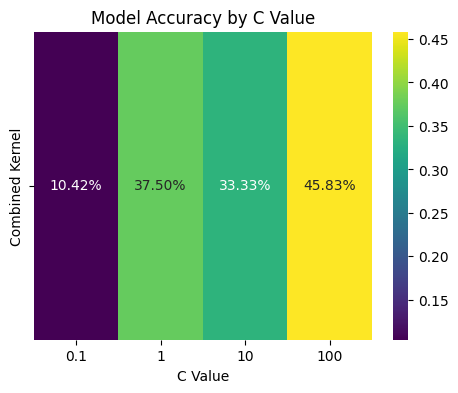

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure to display accuracy as a heatmap
plt.figure(figsize=(12, 4))

# 1. Accuracy heatmap by C value
accuracies = np.array([[result['accuracy'] for result in custom_results]])
plt.subplot(1, 2, 1)
sns.heatmap(accuracies, annot=True, fmt='.2%', cmap='viridis',
            xticklabels=costs, yticklabels=['Combined Kernel'])
plt.xlabel('C Value')
plt.title('Model Accuracy by C Value')
